# Weak Light Tracking Seminar

## Helper Code

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import pandas as pd

from scipy.signal import hilbert, welch
from scipy.stats import norm
from scipy import integrate

import sys
import PLL_FUNCS as PLL


from IPython.display import Image, display, HTML, Markdown

# import siunitx package for si units in mathjax

runCode = True # set to True to run code, False to use saved figures
figure_number = 1


def show_image_with_caption(filepath, caption, scale=1.0, font_size=25):
    global figure_number
    # Create an HTML string with the figure number, caption, and scale
    html = f"<div style='background-color:white; padding:10px; color:black;'><figure style='text-align:center;'><img src='{filepath}' style='width:{scale*100}%'/><figcaption style='text-align:center; font-size:{font_size}px;'><b>Figure {figure_number}:</b> {caption}</figcaption></figure></div>"
    # Display the HTML string
    display(HTML(html))
    figure_number += 1

def show_image_caption_with_markdown(filepath, caption, scale=1.0, font_size=5):
    global figure_number
    # Create the markdown string with the figure number, caption, and scale
    html = f"<div style='background-color:white; padding:10px; color:black;'><figure style='text-align:center;'><img src='{filepath}' style='width:{scale*100}%'/></figure></div>"
    markdown = f"**Figure {figure_number}:** {caption}\n\n"
    # rewrite centered 
    markdown = markdown.replace('**Figure', f"**<font size='{font_size}'><center>Figure")
    # rewrite markdown string with fontsize.
    
    # Display the markdown string
    display(HTML(html))
    display(Markdown(markdown))
    figure_number += 1


In [2]:
filepath = 'Figs/diagram.png'
caption = '''Simplified weak-light optical experiment. $\omega_L$, optical source frequency (193 THz for our case); AOM, acousto-optic modulator; $\omega_1$, AOM frequency shift; VOA, variable optical attenuator; $\omega_2$, VOA frequency shift; PD, photodetector; 
$\phi$, some phase shift that is our signal of interest; BPF, band-pass filter; PLL, phase-locked loop'''

show_image_caption_with_markdown(filepath, caption, scale = 0.5, font_size=5)


**<font size='5'><center>Figure 1:** Simplified weak-light optical experiment. $\omega_L$, optical source frequency (193 THz for our case); AOM, acousto-optic modulator; $\omega_1$, AOM frequency shift; VOA, variable optical attenuator; $\omega_2$, VOA frequency shift; PD, photodetector; 
$\phi$, some phase shift that is our signal of interest; BPF, band-pass filter; PLL, phase-locked loop



At the photodetector, the electric field of light is given by the following equation:

$$ E_{PD}(t) = \sqrt{P_{LO}}e^{j\omega_Lt+\omega_1 t} + \sqrt{P_{sig}}e^{j\omega_Lt+\phi}$$

where $P_{LO}$ is the power of the local oscillator (optical source in Figure 1), $P_{sig}$ is the power of the signal (optical power after attenuation), $\omega_L$ is the frequency of the optical local oscillator, $\omega_1$ is the frequency of the AOM, and $\phi$ is some phase shift that we want to measure.

In this simplified example, we have a weak optical signal, such that $P_{sig} \ll P_{LO}$, that encoded useful information in $\phi$. Weak-light tracking has applications in:
- Future gravitational wave missions such as GRACE. Where interspacecraft laser interferometry is used to measure the change in displacements between spacecrafts, with the goal of measuring gravitational waves.
- Frequency modulated and phase modulate continuous wave LiDAR systems. Where the phase shift of the signal is used to measure the distance between the optical source and the target. Usually this is through stray reflections of the signal, and is likely to be weak light.
- For our purposes, we want to compare the stability of optical clocks from ground to space. This will involve transmitting the optical reference signal from the ground to a satellite, and measuring the phase shift of the signal at the spacecraft, and vice-versa.

With the context in mind, we can begin to analyse the simplified experiment.

For a square-law detector, the photodetector can only responds to:

$$ P_{OPT} = |E_{PD}|^2 = P_{LO} + P_{sig} + 2\sqrt{P_{LO}P_{sig}}cos(\omega_1t+\phi)$$

The photocurrent generated by the photodetector is given by:

$$ \bar{I} = \bar{I}_{LO} + \bar I_{sig} + 2\sqrt{\bar{I}_{LO}\bar{I}_{sig}}cos(\omega_1t+\phi)$$

This photocurrent is made up of a DC offset $\bar{I}_{LO}+\bar{I}_{sig}$, where $\bar{I}_{LO}$ is the noisy LO current, and $\bar{I}_{sig}$ is the noisy signal current. The second term is the AC component of the photocurrent, which contains our signal of interest $\phi$, which will also have its own noise properties. The photocurrent will be converted to a measurable voltage with a transimpedance amplifier. For the purposes of this seminar, we don't need to consider the amplifier, as we only care about the noise properties of our signals. We will come back to this equation later, and how the noise properties are defined, for now let's consider how noise sources affect the signal.


The two noise types we will consider are:
- Additive noise: The noise that is added on to our signal of interest, which is just amplitude noise.
- Phase noise: The noise that affects the phase of our signal of interest.

A simplified model of the noise sources is given by:

$$v(t)=A\cos(\omega t + \theta(t) + \bar{\epsilon}(t)) + \bar{A}(t)$$

where $v(t)$ is the voltage of the signal input to our phase measurement device, $A$ is the amplitude of the signal, $\omega$ is the frequency of the signal, $\theta$ is the deterministic phase of the signal we want to measure, $\bar{\epsilon}(t)$ is the phase noise, and $\bar{A}(t)$ is the amplitude noise. We can usually lump the phase we're interested in measuring, and its noise together.

A phase-locked loop (PLL) can be used to measure the phase of the signal. For the following, it is useful to think of the PLL as a device that outputs the phase $\phi(t)$, where,

$$ \phi(t) = \theta(t) + \bar{\epsilon}(t) + k \bar{A}(t). $$

Here, $\phi(t)$ is the total phase of the signal, $\theta(t)$ is the signal we want to measure, $\bar\epsilon$ is the phase noise, and $k\bar{A}(t)$ is the amplitude noise. Here, $k$, is just to show that the amplitude noise couples into our measurement. We will work out very shortly how it does so.


In [3]:
filepath = 'Figs/phasor.png'
caption = """Phasor diagram of the noisy measurement signal. $\omega$, the rate at which our phasor spins; $\\bar\\phi$ the phase that our PLL will measure; $A$, the amplitude (magnitude) of the measurement signal; 
$\\bar A$, the additive amplitude noise in the measurement signal; $\\bar\epsilon$, the phase noise of the signal."""
show_image_caption_with_markdown(filepath, caption, scale = 0.3)

**<font size='5'><center>Figure 2:** Phasor diagram of the noisy measurement signal. $\omega$, the rate at which our phasor spins; $\bar\phi$ the phase that our PLL will measure; $A$, the amplitude (magnitude) of the measurement signal; 
$\bar A$, the additive amplitude noise in the measurement signal; $\bar\epsilon$, the phase noise of the signal.



To avoid confusion, the phasor model can be separated into its time varying component and its phase component (ignoring additive noise):

$$ v(t) = \Re(Ae^{j\omega t}e^{j\phi})$$

and the ideal PLL measurement will be given by:

$$ v(t) = \text{Arg}(Ae^{j\omega t}e^{j\phi}\times e^{-j\omega t})=\phi$$

There are a few ways to figure out how $\bar A$ will couple into the phase measurement from the PLL. I'm going to run through a derivation that uses the Hilbert transform, as it is essentially a mathematical description of the phasor diagram above. The goal is to find how the noise output, $S_{PLL}(f)$, depends on the phase noise $S_{\bar\phi}(f)$ and the additive noise $S_{\bar A}(f)$, where $S(f)$ is the noise power spectral density.

While not technically defined, this derivation will use:

$$S(f)=\lim_{T\rightarrow\infty}\frac{1}{T}|\mathcal{F}(x(t))|^2$$

where $\mathcal{F}$ is the Fourier transform, and $x(t)$ is the signal of interest. A more rigorous approach would be to consider the auto-correlation of our signals.

Considering our noise model,
$$v(t) = A cos(\omega_i t + \theta_i + \bar{\epsilon}(t))+\bar{A}(t)$$
Take the Hilbert transform,
$$\mathscr{H}\{v(t)\}=Asin(\omega_i t + \theta_i + \bar{\epsilon}(t))+\mathscr{H}\{\bar{A}(t)\}$$
Form the analytic signal,
$$u(t) = A cos(\omega_i t + \theta_i + \bar{\epsilon}(t))+\bar{A}(t) + j[Asin(\omega_i t + \theta_i + \bar{\epsilon}(t))+\mathscr{H}\{\bar{A}(t)\}]$$
The instantaneous phase $\bar{\phi}(t)$ is given by the argument of this analytic signal (which is the phase of the phasor drawn in Figure 2),
$$\bar{\phi}(t) = \tan^{-1} [\frac{Asin(\omega_i t + \theta_i + \bar{\epsilon}(t))+\mathscr{H}\{\bar{A}(t)\}}{A cos(\omega_i t + \theta_i + \bar{\epsilon}(t))+\bar{A}(t)}]$$
For small $x,y$ it can be shown using a taylor expansion of $x$ and $y$
that,
$$tan^{-1}[\frac{sin(\alpha)+x}{cos(\alpha)+y}]\approx \alpha + x cos(\alpha) - y sin(\alpha)$$
from which it follows for small noise fluctuations $\bar{A}(t)$ that,
$$\bar{\phi}(t) = \omega_i t + \theta_i + \bar{\epsilon}(t) + \frac{\mathscr{H}\{\bar{A}(t)\}}{A}\cos(\omega_i t + \theta_i + \bar{\epsilon}(t)) - \frac{\bar{A}(t)}{A}\sin(\omega_i t + \theta_i + \bar{\epsilon}(t))$$
We can ignore the contribution from the frequency and static offset,
providing $$\begin{aligned}
    \bar{\phi(t)}=\bar{\epsilon}(t)+\frac{\mathscr{H}\{\bar{A}(t)\}}{A}\cos(\omega_i t + &\theta_i + \bar{\epsilon}(t)) - \frac{\bar{A}(t)}{A}\sin(\omega_i t + \theta_i + \bar{\epsilon}(t))\\
    \bar{\phi(t)} &= \bar{\epsilon}(t)+ A'(t)
\end{aligned}$$ From this it is clear that, $$\begin{aligned}
    S_{\phi,\epsilon}(f)=S_{\epsilon}(f)
\end{aligned}$$ which is expected. 

It is a bit more involved to work out the contribution from the additive noise. Let's just consider the additive noise now,

$$ \bar{\phi(t)}=\frac{\mathscr{H}\{\bar{A}(t)\}}{A}\cos(\omega_i t + \theta_i + \bar{\epsilon}(t)) - \frac{\bar{A}(t)}{A}\sin(\omega_i t + \theta_i + \bar{\epsilon}(t)) $$

Using the property of the Hilbert transform $\mathcal{F}(\mathcal{H}(x(t)))=-j \mathcal{F}(x(t))$,

$$ \mathcal{F}(\bar{\phi}(t)) = \mathcal{F}\{\frac{\mathcal{H}\{\bar{A}(t)\}}{A}\cos(\omega_i t + \theta_i + \bar{\epsilon}(t))\} + \mathcal{F}\{-\frac{\bar{A}(t)}{A}\sin(\omega_i t + \theta_i + \bar{\epsilon}(t))\} $$

Which when using the convolution property,

$$ \mathcal{F}(\bar{\phi}(t)) = \mathcal{F}\{\frac{\mathcal{H}\{\bar{A}(t)\}}{A}\} \ast \mathcal{F}\{\cos(\omega_i t + \theta_i + \bar{\epsilon}(t))\} + \mathcal{F}\{-\frac{\bar{A}(t)}{A}\} \ast \mathcal{F}\{\sin(\omega_i t + \theta_i + \bar{\epsilon}(t))\} $$
$$ \mathcal{F}(\bar{\phi}(t)) = -j\frac{\mathcal{F}\{\bar{A}(t)\}}{A} \ast \frac{1}{2}[\delta(f-f_i)+\delta(f+f_i)] + \mathcal{F}\{\frac{\bar{A}(t)}{A}\} \ast \frac{1j}{2}[-\delta(f-f_i)+\delta(f+f_i)] $$


Define $\bm{A}(f)=\mathcal{F}\{\bar A(t)\}$,

$$ \mathcal{F}(\bar{\phi}(t)) = \frac{1}{2A}[-j\bm{A}(f-f_i)-j\bm{A}(f+f_i)-j\bm{A}(f-f_i)+j\bm{A}(f+f_i)]=\frac{-1j}{A}\bm{A}(f-f_i) $$

Jumping a step, we can write the power spectral density of the phase noise as,

$$ S_{\phi, A}(f) = \frac{1}{A^2} S_{\bar A}(f-f_i)$$

For our case, we only want to consider the single sided PSD, so we can write,

$$ S_{\phi, A}(f) = \frac{2}{A^2} S_{\bar A}(f)$$

**Discuss the implications of this equation! Think about SNR.**

# Additive Noise and Phase Noise

In the previous section, we derived the power spectral density of the phase noise due to additive noise. We found that the power spectral density of the phase noise due to additive noise is given by:

$$ S_{\phi, A}(f) = \frac{2}{A^2} S_{\bar A}(f)$$

This equation tells us that the power spectral density of the phase noise due to additive noise is inversely proportional to the square of the amplitude of the signal. This means that the phase noise due to additive noise will be more significant for weaker signals. 

Before we knuckle in to weak-light tracking, I think it will be useful to:
- Verify how additive noise and phase noise can couple in to a phase measurement
- Understand how the bandwidth of a measurement signal can change the impact of additive noise on our bandwidth

Recall the **fundamental equation**:

$$ \sigma_{\phi}^2=\int^B_0 S_{\phi}(f) df$$

where $\sigma_{\phi}$ is the variance of the measured phase, $S_{\phi}=S_{\epsilon}(f)+\frac{2}{A^2}S_{\bar A}(f)$, and $B$ is the bandwidth of the measurement device. The following cell is a simulation that:
- Creates band-limited additive white noise and phase noise
- Simulates a simple sinusoid that has this phase noise and additive noise added on to it
- Simulates a perfect PLL measurement of the phase of the signal using the scipy Hilbert transform method
- Calculates the variance of the measured phase
- Looks at the behaviour of the variance of the measured phase as a function of the bandwidth of the measurement device

The total variance of the measured phase is given by:

$$ \sigma_{\phi}^2=\int^B_0 S_{\phi}(f) df = \int^B_0 S_{\epsilon}(f) df + \int^B_0 \frac{2}{A^2}S_{\bar A}(f) df = BS_{\epsilon} + \frac{2B}{A^2}S_{\bar A}$$

where the last equality is true for white noise.

In [4]:
def HilbertPhaseNoise(duration, A, additiveLevel, phaseLevel, B, fs):
    ''' duration: duration of the signal in seconds
        additiveLevel: the additive noise level in the measurement signal
        phaseLevel: the phase noise level in the measurement signal
        B: the bandwidth of the measurement in Hz
        fs: sampling frequency in Hz. 
        Later on I will use IQ data generation as it is more clearer and realistic. This is just a cool tool I found last year.'''
    N = int(fs*duration) # Number of samples
    t = np.arange(0, duration, 1/fs) # Time vector
    amp_noise = additiveLevel * PLL.band_limited_noise(0, B, N, fs) # Generate white additive noise from 0 Hz to fs Hz
    phase_noise = phaseLevel * PLL.band_limited_noise(0, B, N, fs) # Generate white phase noise from 0 Hz to fs Hz
    test_freq = fs/50
    signal = A*np.cos(2*np.pi*test_freq*t + phase_noise) + amp_noise # Generate a cosine signal at 1/50th of the bandwidth, add phase noise and additive noise
    analytic_signal = hilbert(signal) # Calculate the analytic signal
    
    instantaneous_phase = np.unwrap(np.angle(analytic_signal)) # Calculate the instantaneous phase
    instantaneous_phase -= 2*np.pi*test_freq*t # Remove the frequency component from the instantaneous phase

    return t, amp_noise, phase_noise, signal, instantaneous_phase

if(runCode):
    # Quickly verify that the function works, and that noise couples in as expected

    fs = 100000
    duration = 10
    A = 0.5
    additiveLevel = 10
    phaseLevel = 10
    B = 1000

    t, amp_noise, phase_noise, sig, phase = HilbertPhaseNoise(duration, A, additiveLevel, phaseLevel, B, fs)

    plt.figure()
    plt.plot(t, phase, label = "Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Measured Phase Noise")
    fn = "Figs/PhaseNoise.png"
    plt.savefig(fn, dpi = 300)
    plt.close()
    
    f, ampPSD = welch(amp_noise, fs, nperseg = 1024)
    f, phasePSD = welch(phase_noise, fs, nperseg = 1024)
    f, sigPSD = welch(sig, fs, nperseg = 1024)

    amp_std = np.sqrt(B*np.max(ampPSD))/A #cycles
    phase_std = np.sqrt(B*np.max(phasePSD))#std_dev/np.sqrt(2) #already in cycles
    tot_std = np.sqrt(amp_std**2 + phase_std**2)
    
    plt.figure()
    counts, bins = np.histogram(phase, density = True, bins = 100)
    plt.stairs(counts, bins, label = "Calculated Histogram", color = "tab:blue")
    plt.title("Error Histogram")
    plt.grid()

    (mu, sigma) = norm.fit(phase)
    plt.plot(bins, norm.pdf(bins, mu, sigma), label = "Fitted Histogram", c = "tab:orange")
    plt.plot(bins, norm.pdf(bins, mu, tot_std), label = "Estimated (theory) Histogram", c = "tab:green")
    plt.legend()
    plt.title(r'$\mathrm{Simulated\ Phase\ Noise\ Histogram\:}\ \mu=%.3f,\ \sigma=%.4f$' %(mu, sigma))
    print("Numerical STD Dev: " + str(sigma) + "\n")
    print("Expected STD Dev: " + str(tot_std) + "\n")

    fn = "Figs/PhaseNoiseHist.png"
    plt.savefig(fn, dpi = 300)
    plt.close()

    ## CONSTANT NOISE PROFILE, BUT DECREASING AMPLITUDE

    amps = np.linspace(0.5, 0.05, 10)
    std_devs = []
    for A in amps:
        t, amp_noise, phase_noise, sig, phase = HilbertPhaseNoise(duration, A, additiveLevel, phaseLevel, B, fs)
        (mu, sigma) = norm.fit(phase)
        std_devs.append(sigma)

    plt.figure()
    plt.plot(amps, std_devs)
    plt.xlabel("Signal Amplitude (Volts [V])")
    plt.ylabel("Phase Noise Standard Deviation [cycles]")
    plt.title("Phase Noise Standard Deviation vs Signal Amplitude")
    fn = "Figs/PhaseNoiseAmpStd.png"
    plt.savefig(fn, dpi = 300)
    plt.close()
    ## CONSTANT AMPLITUDE PROFILE, BUT CHANGING BANDWIDTH

    Bs = np.linspace(1, 1000, 10)
    A = 0.05
    std_devs = []
    for B in Bs:
        t, amp_noise, phase_noise, sig, phase = HilbertPhaseNoise(duration, A, additiveLevel, phaseLevel, B, fs)
        (mu, sigma) = norm.fit(phase)
        std_devs.append(sigma)

    plt.figure()
    plt.plot(Bs, std_devs)
    plt.xlabel("Measurement Bandwidth (Hz)")
    plt.ylabel("Phase Noise Standard Deviation [cycles]")
    plt.title("Phase Noise Standard Deviation vs Measurement Bandwidth")
    fn = "Figs/PhaseNoiseBandStd.png"
    plt.savefig(fn, dpi = 300)
    plt.close()

fn = "Figs/PhaseNoise.png"
show_image_with_caption(fn, "Measured Phase Noise", scale = 0.5)
fn = "Figs/PhaseNoiseHist.png"
show_image_with_caption(fn, "Error Histogram", scale = 0.5)
fn = "Figs/PhaseNoiseAmpStd.png"
show_image_with_caption(fn, "Phase Noise Standard Deviation vs Signal Amplitude", scale = 0.5)
fn = "Figs/PhaseNoiseBandStd.png"
show_image_with_caption(fn, "Phase Noise Standard Deviation vs Measurement Bandwidth", scale = 0.5)

Numerical STD Dev: 0.0031622166763705553

Expected STD Dev: 0.003178749922064814



This gives an idea of how the weak-light problem can be solved. **However**, it neglects two very important things:
- The signal of interest is likely changing in frequency. If our bandwidth is 1Hz, what happens if our signal changes by 10 Hz?
- This also ignores the dynamics of a PLL. There's more to the optimisation than simply decreasing bandwidth.

With this in mind, let's go back to weak light.

# Weak Light Statistics

Recall from above that the photocurrent generated by the photodetector is given by:

$$ P_{OPT} = |E_{PD}|^2 = P_{LO} + P_{sig} + 2\sqrt{P_{LO}P_{sig}}cos(\omega_1t+\phi)$$
$$ \bar{I} = \bar{I}_{LO} + \bar I_{sig} + 2\sqrt{\bar{I}_{LO}\bar{I}_{sig}}cos(\omega_1t+\phi)$$


Let's briefly consider the statistics of light (in a very non-rigorous manner).

The photon flux $\Phi$ incident on a photodetector is given by:

$$ \Phi = \frac{P}{hf}$$

where $P$ is the power of the light, $h$ is Planck's constant, and $f$ is the frequency of the light. From quantum theory (**Is this actually a derivable result from quantum?**), the number of photons detected by a photodetector follows a Poisson distribution. The **mean** number of photons incident on the photodetector in an observation time interval $T$ is given by:

$$ \bar{N} = \Phi T = \frac{P}{hf}T$$

The **variance** of the number of photons incident on the photodetector in an observation time interval $T$ is given by:

$$ \sigma_N^2 = \bar{N} = \frac{P}{hf}T$$

**Note: I don't really like these statistics. As mean would have a unit, while variance has a unit^2. But one explanation is that counts are unitless...**

The mean number of photoelectrons generated by the photodetector with quantum efficiency $\eta$ in an observation time interval $T$ is given by:

$$ \bar{m}=\eta \bar{n}$$
$$ \sigma_m^2 = \eta \bar{n}$$

The average photocurrent generated by the photodetector is given by:

$$ \bar{I} = \frac{q}{T} \bar{m} = \frac{\eta q P}{h f}$$

where $q$ is the charge of an electron. The variance of the photocurrent generated by the photodetector is given by:

$$ \sigma_I^2 = (\frac{q}{T})^2 \sigma_m^2 = \frac{2B \eta q^2 P}{h f}=2 B q \bar{I} $$

where $\frac{1}{T}=2B=f_s$. Recall $ \sigma^2=\int^B_0 S(f) df$, which would suggest that,

$$ S(f) = 2 q \bar{I}$$

This is the quantum noise limit of the measured photocurrent, otherwise known as shot noise. A rigorous derivation of would consider the photocurrent as,

$$ I(t)=q \sum \delta(t-t_i)$$

where $t_i$ is a set of poisson random variables. It would then show that the autocorrelation is,

$$ R_I(\tau)=q \bar{I} \delta(\tau) + \bar{I}^2$$

which contains a white noise term, the shot noise, and a DC term related to the average photocurrent I. 

These statistics provide the shot-noise limit for a photodetector, and is directly obtained from the quantum nature of light.

## Brief Aside (Shot Noise Limited Measurement)

The shot noise limit is the best possible measurement that can be made with a photodetector. However, other noise sources will likely trump it. Some noise sources of cosnideration are:
- Amplifier noise
- Thermal (Johnson-Nyquist) noise
- Dark current (photocurrent generated in the absence of light)

In a direct detection system, we have no control over what the shot noise is since

$$ \bar{I}_{meas}= \bar{I}_{sig}$$

However, for heterodyne detection

$$ \bar{I} = \bar{I}_{LO} + \bar I_{sig} + 2\sqrt{\bar{I}_{LO}\bar{I}_{sig}}cos(\omega_1t+\phi) \approx \bar{I}_{LO}$$

when $I_{LO}>>>I{sig}$ (think milliwatts to sub picowatts). This means that the shot noise limit is given by the local oscillator power, and not the signal power. This is a key advantage of heterodyne detection, as we can simply increase the power of the local oscillator, to make the quantum noise the dominant noise source. For the purposes of weak-light tracking, and this seminar, we will only consider additive shot noise.

## Shot Noise Limited Phase Measurement

We can now finally consider how the additive shot noise will couple in to a phase measurement.

$$ \bar{I}_{LO} = \frac{\eta q \lambda}{2\pi\hbar c}P_{LO}$$
$$ \bar{I}_{sig} = \frac{\eta q \lambda}{2\pi\hbar c}P_{sig}$$
$$ S_{SN}(f) \approx 2 q \bar{I}_{LO} = \frac{\eta q^2 \lambda}{\pi \hbar c}P_{LO}$$
$$ S_{AN} = \frac{2}{A^2}S_{SN}(f)$$
$$ A^2 = 4 \bar{I}_{LO} \bar{I}_{sig} = \frac{\eta^2 q^2 \lambda^2 P_{LO} P_{sig}}{\pi^2 \hbar^2 c^2}$$
$$ S_{AN} =2 (\frac{\pi^2 \hbar^2 c^2}{\eta^2 q^2 \lambda^2 P_{LO} P_{sig}})(\frac{\eta q^2 \lambda}{\pi \hbar c}P_{LO}) = \frac{2\pi\hbar c}{\eta\lambda P_{sig}}\hspace{4pt}[\text{rad}^2/\text{Hz}] = \frac{\hbar c}{2\pi\eta\lambda P_{sig}}\hspace{4pt}[\text{cyc}^2/\text{Hz}]$$

This analysis provides an interesting problem. The shot noise limit of the measurement on $P_{LO}$, however, the way that shot noise couples into the phase measurement depends inversely on $P_{sig}$. This is essentially the weak-light problem, as the signal power decreases, our phase measurement will see much more additive noise! **Discuss!**.

## Phase Noise

I've mostly glossed over phase noise, as a big part of the weak-light problem is additive shot noise. To keep it simple for this seminar, we will use

$$ S_{\phi}(f)=(\frac{\nu}{2\pi f})^2\hspace{4pt}[\text{cyc}^2/\text{Hz}]$$

where $\nu$ is the white level of the laser frequency noise in $[\text{Hz}/\sqrt\text{Hz}]$ .

# Phase Locked Loops

In [5]:
caption = """PLL feedback structure."""

show_image_caption_with_markdown("Figs/PLL.png", caption, scale=0.3)
show_image_caption_with_markdown("Figs/PLL_s.png", "PLL phase model in s-domain. For digital PLLs, the LO is usally a numerically controlled oscillator (NCO).", scale=0.3)


**<font size='5'><center>Figure 7:** PLL feedback structure.



**<font size='5'><center>Figure 8:** PLL phase model in s-domain. For digital PLLs, the LO is usally a numerically controlled oscillator (NCO).



For our purposes, we will keep the PLL model simple and do everything in $f$ domain. The NCO (local oscillator for a digital PLL) has a transfer function

$$ P(f) = \frac{K}{jf}$$

where the division by $jf$ indicates that the controller actuates the frequency of the NCO.

The open loop gain of the PLL is given by

$$ G(f) = \frac{K}{jf} F(f) $$

The controller I usually opt for is either a proportional-integral or proportional-integral squared controller. 

$$ F(f) = P + \frac{I}{jf}$$

for $P$ the proportional gain, and $I$ the integral gain.

The open-loop transfer function is then,

$$ G(f) = \frac{K}{jf} (P + \frac{I}{jf}) = \frac{-j K_v P}{f} - \frac{K_v I}{f^2}$$

the I-term is usually much smaller than the P-term, and is used to ensure stability of the control loop. When considering the open-loop gain of the transfer function, we will usually only consider the P-term.

$$ G(f) = \frac{-j K P}{f} = \frac{-j f_{ug}}{f}$$

where we have defined the unity gain frequency $f_{ug} = K P$ (the frequency at which $|G_{OL}(f)|=1$). $K$ is the gain of the oscillator, and for our case it will just be $2\pi$. The unity gain frequency provides a metric for the bandwidth of the PLL, as we will soon see.

# Propagation of phase noise and additive noise in a PLL (brief overview, just copy-pasted from other notebook. Explains how additive noise enters PLL)


It is worthwhile exploring how phase noise and amplitude noise are
perceived by a PLL. This analysis will be done in the continuous time
domain, as the results will be analogous to discrete time. We begin by
considering a noisy signal,
$$v(t) = A[1+\alpha(t)]\sin(\omega_i t + \theta_i + \bar{\epsilon}(t))$$
where $\alpha(t)$ are random WSS fractional amplitude oscillations of
the signal, and $\bar{\epsilon}(t)$ are random WSS fractional phase
changes. A more useful form of this oscillator is,

$$ v(t) = A\sin(\omega_i t + \theta_i + \bar{\epsilon}(t)) + \bar{A}(t)$$
$$\bar{A}(t) = A\alpha(t)\sin(\omega_i t + \theta_i + \bar{\epsilon}(t))$$ 
where $\bar{A}(t)$ is additive noise on the signal,
centered at the carrier frequency $\omega_i$. For now, we shall ignore
the random phase fluctuations, and consider how additive noise is
propagated in the loop (we can safely do this as our final model will be
a linear one, or consider the phase noise being absorbed by $\theta_i$).

Using Euler's or sum idenities, $$\begin{aligned}
    \bar{A}(t) &= A\alpha(t) \sin(\omega_i t) \cos(\theta_i) + \cos(\omega_i t)\sin(\theta_i)\\
    \bar{A}(t) &= n_c(t)cos(\omega_i t) - n_s(t)sin(\omega_i t)\\
    n_c(t) &= A\alpha(t) \sin(\theta_i)\\
    n_s(t) &= -A\alpha(t) \cos(\theta_i)
\end{aligned}$$

This is the band passed noise process $\bar{A}(t)$ decomposed into two
quadrature, and independant components (NOTE: The textbook derivation
I've found uses Fourier transform, I find this simpler). We now
introduce the locked NCO, $$v_{NCO}(t) = B\sin(\omega_i t + \theta_o)$$
The NCO and input are mixed, and lowpass filtered to remove high
frequency components, providing $$\begin{aligned}
    v_{error}(t) &= v(t)v_{NCO}(t) = B\sin(\omega_i t + \theta_o)(A\cos(\omega_i t + \theta_i) + n_c(t)cos(\omega_i t) - n_s(t)sin(\omega_i t))\\
    v_{error,LPF} &= \frac{AB}{2}(\sin(\theta_i - \theta_o) + \frac{n_c(t)}{A}\cos(\theta_o) + \frac{n_s(t)}{A}\sin(\theta_o))
\end{aligned}$$

The equivalent noise $n'(t)$ is then defined, $$\begin{aligned}
    n'(t) &= \frac{n_c(t)}{A}\cos(\theta_o) + \frac{n_s(t)}{A}\sin(\theta_o)\\
    v_{error,LPF} &= \frac{AB}{2}(\sin(\theta_i - \theta_o) + n'(t))
\end{aligned}$$

This final equation is quite important. Essentially, this equivalent
noise is inserted just after the linear phase detector. To see this,
consider the non-linear model of the mixer,

In [6]:
show_image_caption_with_markdown("Figs/Additive_NonLin.png","Non linear phase detector", scale=0.5)

**<font size='5'><center>Figure 9:** Non linear phase detector



In the linear model, this $\sin(t)$ term becomes unity, and the
equivalent noise is inserted just after the linear phase detector. We
must still quantify how $n'(t)$ relates to $\bar{A}(t)$ (further work
could maybe done to then relate to $\alpha(t)$, but this is not
necessary for additive shot noise). We know $n(t)$ is zero-mean, and
hence $n'(t)$ will also be zero mean. Following from this,
$$\begin{aligned}
    \text{VAR}(n'(t)) &= E[n'(t)^2] = \sigma_{n'}^2\\
    n'(t)^2 &= \frac{n_c^2}{A^2}\cos^2(\theta_o) + \frac{n_s^2}{A^2}\sin^2(\theta_o) + \frac{2n_c n_s}{A^2}\cos(\theta_i)\sin(\theta_o)\\
    E[n_c^2]&=E[n_s^2]=E[n^2]=\text{VAR}(n(t))=\sigma^2_n\\
    E[n_cn_s] &=0
\end{aligned}$$ 
Where the properties of bandpass gaussian noise provide
convenient statistical relationships.
$$\text{VAR}(n'(t)) = \frac{\text{VAR}(n(t))}{A^2} = \frac{\sigma_n^2}{A^2} = \sigma_{n'}^2$$

The autocorrelation is then calculated as, $$\begin{aligned}
    R_{n'}(\tau) = E[n'(t)n'(t+\tau)] = \frac{E[n_c(t)n_c(t+\tau)]}{A^2}&E[\cos^2\theta_o]+\frac{E[n_s(t)n_s(t+\tau)]}{A^2}E[\sin^2\theta_o]\\
    E[cos^2]&=E[sin^2]=0.5\\
    E[n_c(t)n_c(t+\tau)]&=E[n_s(t)n_s(t+\tau)]=R_{nc}(\tau)\\
    R_{n'}(\tau) &= \frac{R_{nc}(\tau)}{A^2}
\end{aligned}$$

The **single sided** spectrum is then,
$$S_{n'}(f) = \frac{2 S_{nc}(f)}{A^2}$$ 
where $S_{nc}(f)$ is the Fourier
transform of $R_{nc}(\tau)$. This spectrum is related to the additive
noise spectrum $S_n(f)$ by, $$S_{nc}(f) = S_n(f-f_i)$$ where
$f_i=\omega_i/2\pi$, and the PSD has been shifted to $f_i$.
I don't fully understand yet how this is derived, but Gardner kinda
states it. Conceptually, the spectrum of the additive noise is centered
about the carrier frequency $\omega_i$. The one sided $S_n(f)$ is equal
to 0 for $f<0$. For white noise, $S_n(f)=N_0 \quad [V^2/Hz]$,
$$S_{n'}(f) = \frac{2 N_0}{A^2} \quad [rad^2/Hz]$$ 
where the additive
noise process is now considered as an angular disturbance.

# Phase locked loops continued

For signal noise $\phi_{sig}(f)$ and additive phase noise $\phi_{AN}(f)$, we can determine the following transfer functions:

$$ E(f) = \frac{\phi_{error}(f)}{\phi_{signal}(f)}=\frac{1}{1+G_{OL}(f)}$$
$$ H(f) = \frac{\phi_{error}(f)}{\phi_{AN}(f)}=\frac{G_{OL}(f)}{1+G_{OL}(f)}$$

which model how phase and shot noise are seen at the output of our "imaginary" phase detector. For the perfect measurement, we would expect $\phi_{error}$ to be zero, which means that our local oscillator is perfectly tracking the incoming signal and that our measurement is perfectly $\phi_{sig}$. These transfer functions model how incorrect our measurement will be. To **estimate** the error in the phase detector, due to phase noise and additive noise, we can use the following equations:

$$ \sigma_{error}^2 = \int^B_0 S_{\phi}(f) |E(f)|^2 df + \int^B_0 S_{AN}(f)|H(f)|^2 df $$

For the weak light problem, we have,

$$ S_{AN} = \frac{\hbar c}{2\pi\eta\lambda P_{sig}}\hspace{4pt}[\text{cyc}^2/\text{Hz}]$$
$$ S_{\phi}(f)=(\frac{\nu}{2\pi f})^2\hspace{4pt}[\text{cyc}^2/\text{Hz}]$$

We now have all the prerequisite knowledge to optimise a PLL for weak-light tracking!

Before doing numerical simulations, let's consider the following:
- In the high gain limit $|G_{OL}|>>1$, $\phi_{error}(f) \approx \phi_{AN}(f)$ (shot noise dominates our tracking error) 
- In the low gain limit $|G_{OL}|<<1$, $\phi_{error}(f) \approx \phi_{sig}(f)$ (we don't track the signal phase!)
- We can optimise the bandwidth of the PLL by finding the optimum $f_{ug}$, that minimises the tracking error $\sigma_{error}^2$.

# Tracking Curves

In [7]:
varCounter = 0

In [8]:
fn = f"Figs/PhaseNoiseVariance_{varCounter}.png"
varCounter += 1

if(runCode):
    optical_powers = np.logspace(-16,-9, 10) #Femtowatt to nanowatt
    unity_gain_freqs = np.logspace(-1, 7, 10000) #Hz

    wave_length = 1550e-9
    c = 299792458
    h = 6.62607015e-34
    hbar = h/(2*np.pi)
    eta = 1 # Assume perfect photodetector
    B = 100e3 # 100 kHz bandwidth
    observation_time = 10
    fmin = 2 / observation_time
    freq_space = np.linspace(fmin, B, 1000)
    white_noise = 1 # Hz/Hz white noise level

    plt.figure()
    for power in optical_powers:
        additive_noise = hbar * c / (2 * np.pi * eta * wave_length * power)
        phase_noise = (white_noise/(2 * np.pi * freq_space))**2
        variances = []
        for fug in unity_gain_freqs:
            openLoop_GAIN = -1j * fug / (2 * np.pi * freq_space)
            E = 1/(1 + openLoop_GAIN)
            H = openLoop_GAIN * E
            phase_variance = integrate.trapz(np.abs(E)**2 * phase_noise, freq_space)
            additive_variance = integrate.trapz(np.abs(H)**2 * additive_noise, freq_space)
            variances.append(phase_variance + additive_variance)
        plt.plot(unity_gain_freqs, np.sqrt(variances), label = f"{power:.2e} W")
    # plot constant line of 0.03^2
    plt.axhline(y=0.03, color='r', linestyle='--', label = "0.03")
    plt.title("Total Phase Error STD dev vs Unity Gain Frequency for Different Optical Powers")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Unity Gain Frequency (Hz)")
    plt.ylabel("Total Phase Error STD Dev ($cyc$)")
    plt.legend()
    plt.savefig(fn, dpi = 300)
    plt.close()

show_image_caption_with_markdown(fn, "Total Phase Error Variance vs Unity Gain Frequency for different optical powers", scale=0.5)
        


**<font size='5'><center>Figure 10:** Total Phase Error Variance vs Unity Gain Frequency for different optical powers



## **Play around with noise values, optical power values and investigate!** Why 0.03?

PLL's usually have a mixer phase detector, which is a non linear device.

$$ V_{error} = \sin(2\pi f t + \theta_{signal})\sin(2\pi f t + \theta_{LO}) = \sin(\theta_{signal}-\theta_{LO})$$

 However, when the PLL is tracking, the small angle approximation

$$ \sin(\theta)\approx\theta$$

and the PLL is safely linear.

But, this approximation grows in error as $\theta$ gets larger. $\sigma_{\theta}=0.03 \text{cyc}$ is the point at which errors in the control loop exceed 1%, which will result in increasingly non-linear behaviour. 

# PLL Simulations

We can still get more improvement by considering the control loop of the PLL. The above $F_{ug}$ analysis just considered the proportional gain, however, the integral gain (and even integral squared gain) can help alleviate the impact of phase noise when the bandwidth must necessarily be bandwidth. To illustrate,

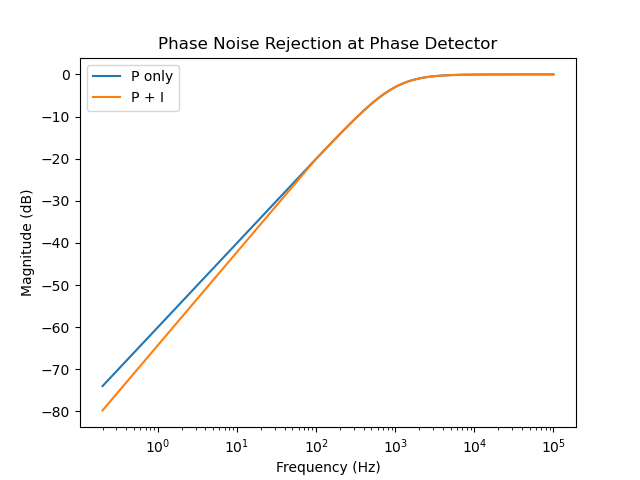

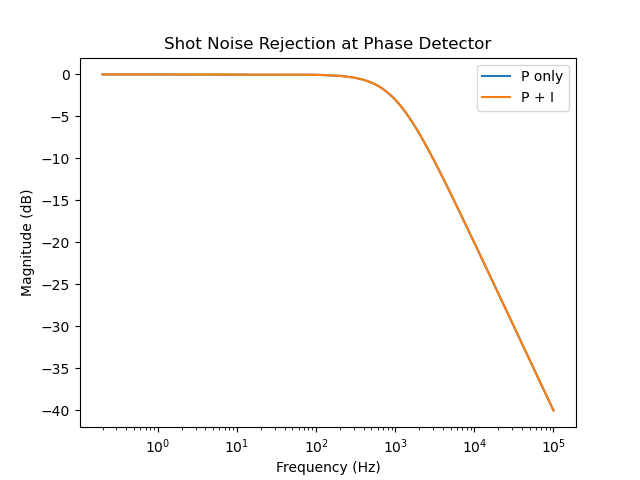

In [9]:
if(runCode):
    fug = 1000
    openLoop_GAIN = -1j * fug / freq_space
    E = 1/(1 + openLoop_GAIN)

    plt.figure()
    plt.plot(freq_space, 10*np.log10(np.abs(E)**2), label = "P only")
    plt.title("Phase Noise Rejection at Phase Detector")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.xscale("log")

    P = fug/(2*np.pi)
    I = P/3
    openLoop_GAIN = -1j * 2 * np.pi * P / freq_space - 2 * np.pi * I / freq_space**2
    E = 1/(1 + openLoop_GAIN)
    plt.plot(freq_space, 10*np.log10(np.abs(E)**2), label = "P + I")
    plt.legend()

    openLoop_GAIN = -1j * fug / freq_space
    E = 1/(1 + openLoop_GAIN)

    plt.figure()
    plt.plot(freq_space, 10*np.log10(np.abs(E*openLoop_GAIN)**2), label = "P only")
    plt.title("Shot Noise Rejection at Phase Detector")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.xscale("log")

    P = fug/(2*np.pi)
    I = P/3
    openLoop_GAIN = -1j * 2 * np.pi * P / freq_space - 2 * np.pi * I / freq_space**2
    E = 1/(1 + openLoop_GAIN)
    plt.plot(freq_space, 10*np.log10(np.abs(E*openLoop_GAIN)**2), label = "P + I")
    plt.legend()


However, once we start thinking about controller design, we need to make sure the controller is stable. There's some more theory to be covered here. But for now, let's just simulate the PLL!

In [10]:
def plotPII2(P, I, I2, freqs, verbosePlot):
    if(verbosePlot):
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
        ax0.plot(freqs, 20*np.log10(np.abs(P_GAIN)), label = 'P')
        ax0.plot(freqs, 20*np.log10(np.abs(I_GAIN)), label = 'I')
        ax0.plot(freqs, 20*np.log10(np.abs(I2_GAIN)), label = 'I2')

        unity_gain_freq = freqs[np.argmin(np.abs(np.abs(P_GAIN) - 1))]
        ax0.axvline(unity_gain_freq, color='r', linestyle='--')

        ax0.legend()
        ax0.set_title('LOOP GAINs Magnitude Response')
        ax0.set_xscale('log')
        ax0.set_yscale('linear')
        # show every power of 10 on xscale
        ax0.set_xticks([10**i for i in range(1, int(np.log10(freqs[-1]))+1)])
        ax0.set_ylabel('Magnitude (dB)')
        ax0.set_xlim([1, freqs[-1]])
        ax0.grid()
        ax1.plot(freqs, np.angle(P_GAIN))
        ax1.plot(freqs, np.angle(I_GAIN))
        ax1.plot(freqs, np.angle(I2_GAIN))
        ax1.set_title('LOOP GAIN Phase Response')

def plotLoopGain(LOOP_GAIN, freqs, verbosePlot):
    if(verbosePlot):
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
        ax0.plot(freqs, 20*np.log10(np.abs(LOOP_GAIN)))
        ax0.set_title('LOOP GAIN Magnitude Response')
        ax0.set_xscale('log')
        ax0.set_yscale('linear')
        ax0.set_ylabel('Magnitude (dB)')
        scale = 360/(2*np.pi)
        ax1.plot(freqs, np.angle(LOOP_GAIN)*scale)
        ax1.set_title('LOOP GAIN Phase Response')
        ax1.set_xscale('log')
        ax1.set_yscale('linear')
        ax1.set_xlabel('Frequency (Hz)')
        ax0.grid()
        ax1.grid()
        unity_gain_freq = freqs[np.argmin(np.abs(np.abs(LOOP_GAIN) - 1))]
        phase_margin = np.angle(LOOP_GAIN[np.argmin(np.abs(freqs - unity_gain_freq))])
        ax0.axvline(unity_gain_freq, color='r', linestyle='--')
        ax1.axvline(unity_gain_freq, color='r', linestyle='--')
        ax1.axhline(phase_margin*scale, color='r', linestyle='--')
        ax1.axhline(- np.pi*scale, color='r', linestyle='--')
        print('Unity Gain Frequency: ', unity_gain_freq)
        print('Phase Margin: ', 180 + phase_margin*180/np.pi)

def plotTF(TF, freqs, verbosePlot):
    if(verbosePlot):
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
        ax0.plot(freqs, 20*np.log10(np.abs(TF)))
        ax0.set_title('Magnitude Response')
        ax0.set_xscale('log')
        ax0.set_yscale('linear')
        ax0.set_ylabel('Magnitude (dB)')
        ax1.plot(freqs, np.angle(TF))
        ax1.set_title('Phase Response')
        ax1.set_xscale('log')
        ax1.set_yscale('linear')
        ax1.set_xlabel('Frequency (Hz)')
        ax0.grid()
        ax1.grid()

Text(0, 0.5, 'Phase Noise [cyc^2/Hz]')

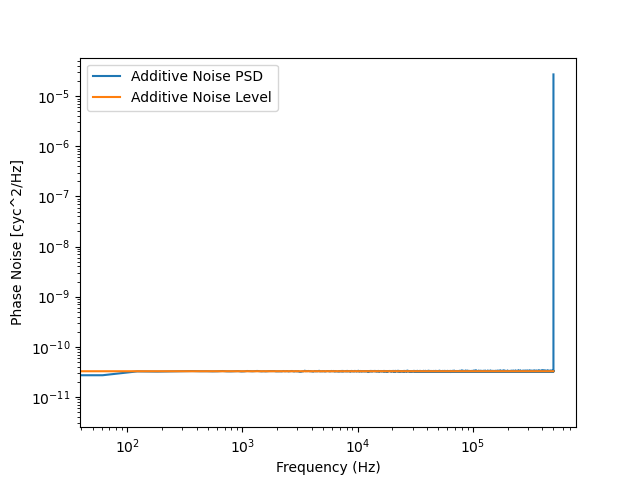

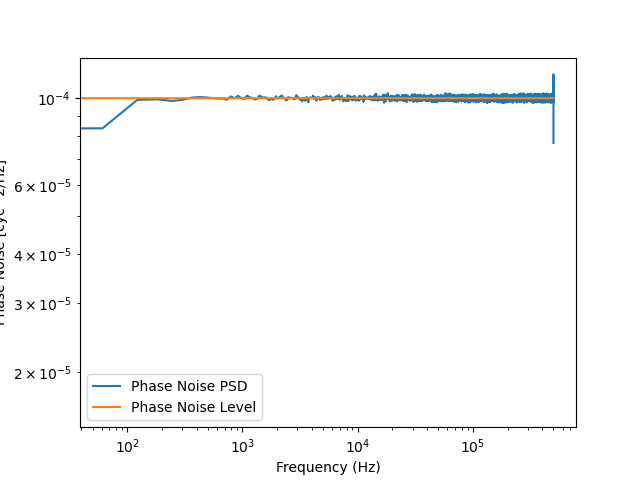

In [11]:
fs = 1e6 # ample sample rate
B = fs
duration = 10
N = int(fs*duration)
t = np.arange(0, duration, 1/fs)

wave_length = 1550e-9
c = 299792458
h = 6.62607015e-34
hbar = h/(2*np.pi)
eta = 1 # Assume perfect photodetector
power = 1e-10# 10 femtowatt
additive_noise_lvl = hbar * c / (2 * np.pi * eta * wave_length * power)
phase_noise_lvl = 1e-4 # White phase noise to make things easy

additive_noise =  PLL.white_psd_noise(additive_noise_lvl, N, fs)

phase_noise =  PLL.white_psd_noise(phase_noise_lvl, N, fs)

f, ampPSD = welch(additive_noise, fs, nperseg = 1024*16)
f, phasePSD = welch(phase_noise, fs, nperseg = 1024*16)

plt.figure()
plt.plot(f, ampPSD, label = "Additive Noise PSD")
plt.plot(f, additive_noise_lvl*np.ones_like(f), label = "Additive Noise Level")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase Noise [cyc^2/Hz]")

plt.figure()
plt.plot(f, phasePSD, label = "Phase Noise PSD")
plt.plot(f, phase_noise_lvl*np.ones_like(f), label = "Phase Noise Level")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase Noise [cyc^2/Hz]")


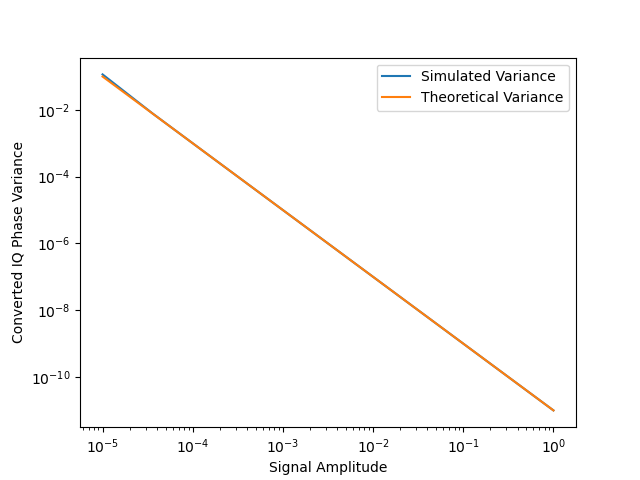

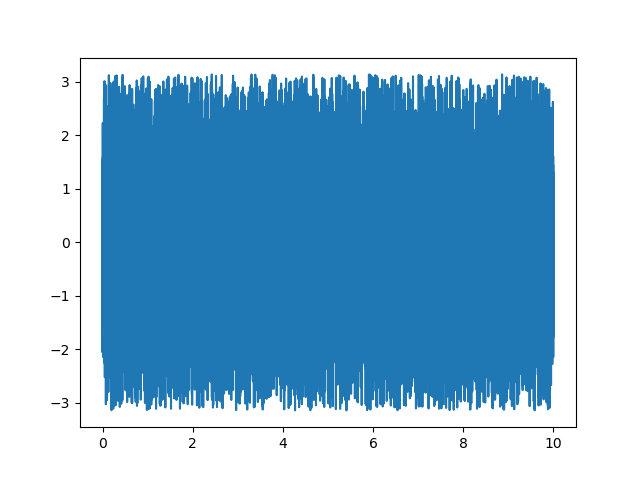

In [12]:
def phaseToIQ(data, tVals, f0, A, additiveNoise, unit = 'cycles'):
    ''' Function to convert phase data to IQ data. f0 is the carrier frequency. Default unit for phase data is cycles.'''
    if unit == 'cycles':
        scale = 2*np.pi
    else:
        scale = 1
    IQ = A * np.exp(1j*(2*np.pi*f0*tVals + scale*data)) + hilbert(additiveNoise) # hilbert transform accounts for the additive noise
    return IQ

additiveNoiseTest = 0.01*PLL.band_limited_noise(0, B, N, fs)
varAdditive = np.var(additiveNoiseTest)

A_test = np.logspace(-5, 0, 10)
variances = []

for A in A_test:
    IQ_test = phaseToIQ(0, t, 0, A, additiveNoiseTest)
    varIQ = np.var(np.angle(IQ_test))
    variances.append(varIQ)



plt.figure()
plt.plot(A_test, variances, label = "Simulated Variance")
plt.plot(A_test, varAdditive/A_test**2, label = "Theoretical Variance")
plt.xlabel("Signal Amplitude")
plt.ylabel("Converted IQ Phase Variance")
plt.xscale("log")
plt.yscale("log")
plt.legend()

A = 10**-5
IQ_test = phaseToIQ(0, t, 0, A, additiveNoiseTest)
plt.figure()
plt.plot(t, np.angle(IQ_test))

## The above just shows that we can add additive noise to the IQ data with the hilbert transform, handy for simulating.

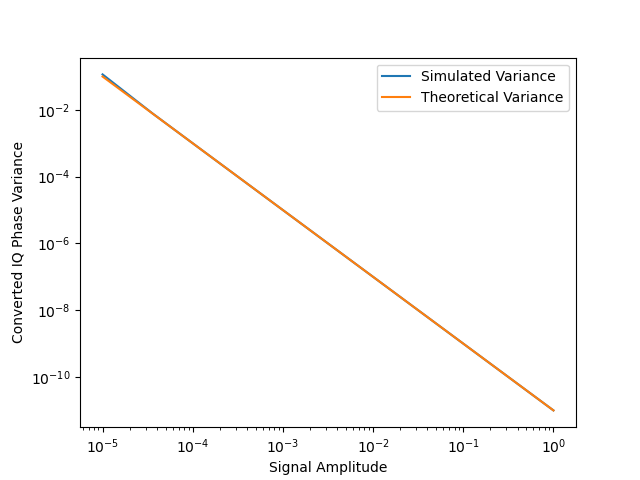

In [13]:
plt.figure()
plt.plot(A_test, variances, label = "Simulated Variance")
plt.plot(A_test, varAdditive/A_test**2, label = "Theoretical Variance")
plt.xlabel("Signal Amplitude")
plt.ylabel("Converted IQ Phase Variance")
plt.xscale("log")
plt.yscale("log")
plt.legend()

4.0059520014366724e-12
Photocurrent Amplitude (A): 250.03 uA


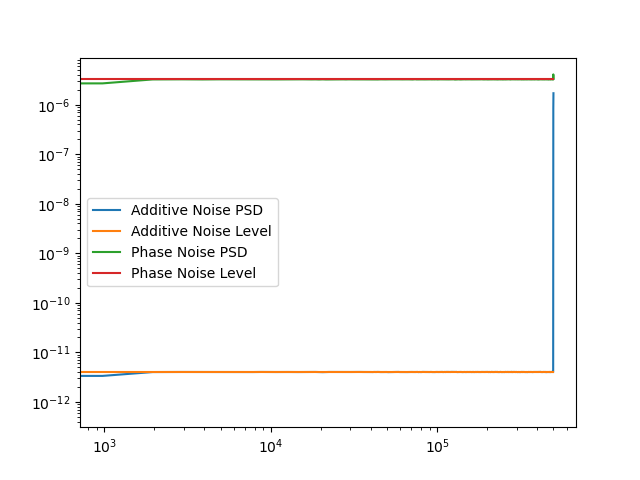

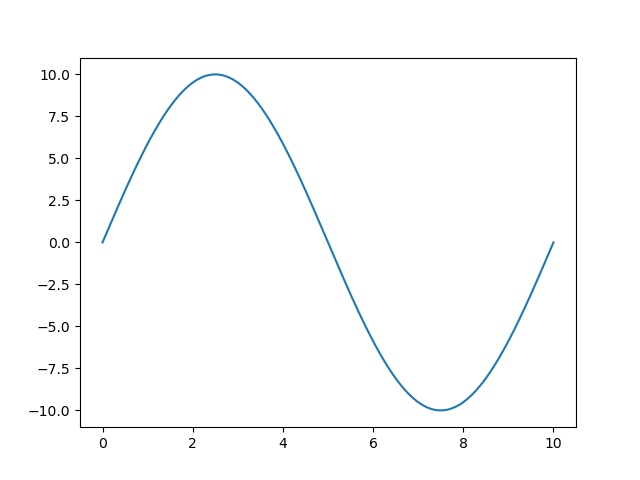

In [61]:
def calc_photon_noise(LO_power, sig_power, duration, fs, GAIN = 1):
    ''' Calculate the shot noise limited photo currents for heterodyne detection. 
    This takes in LO and signal powers in watts, duration in seconds, and sampling frequency in Hz.
    This uses the fact that S_n = 2*q*I_n, where S_n is the shot noise, q is the electron charge, and I_n is the photo current. 
    And I_n = eta*q*P_n/hf, where eta is the quantum efficiency, P_n is the power, h is the planck constant, and f is the frequency of the light.
    '''
    N = int(fs*duration)
    q = 1.60217662e-19 # electron charge
    wave_length = 1550e-9
    c = 299792458
    eta = 1
    h = 6.62607015e-34
    hbar = h/(2*np.pi)
    LO_mean = eta * q * wave_length * LO_power / (h * c)
    SIG_mean = eta * q * wave_length * sig_power / (h * c)
    sig_amp = GAIN * 2 * np.sqrt(LO_mean*SIG_mean)
    shot_noise_level = (GAIN)**2 * 2 * q * LO_mean # Just depends on LO power in weak signal regime
    print(shot_noise_level)

    additive_noise =  PLL.white_psd_noise(shot_noise_level, N, fs)
    
    additive_phase_noise_level = hbar * c / (2 * np.pi * eta * wave_length * sig_power)
    additive_phase_noise =  PLL.white_psd_noise(additive_phase_noise_level, N, fs)

    return sig_amp, additive_noise, shot_noise_level, additive_phase_noise, additive_phase_noise_level


GAIN = 100000
LO_power = 1e-3 # 1 mW
sig_power = 1e-15 # 1 picowatt
sig_amp, additive_noise, add_noise_lvl, additive_phase_noise, add_phase_lvl = calc_photon_noise(LO_power, sig_power, duration, fs, GAIN=GAIN)

print(f"Photocurrent Amplitude (A): {sig_amp*1e6:.2f} uA") 

f, ampPSD = welch(additive_noise, fs, nperseg = 1024)
f, phasePSD = welch(additive_phase_noise, fs, nperseg = 1024)
plt.figure()
plt.plot(f, ampPSD, label = "Additive Noise PSD")
plt.plot(f, add_noise_lvl*np.ones_like(f), label = "Additive Noise Level")
plt.plot(f, phasePSD, label = "Phase Noise PSD")
plt.plot(f, add_phase_lvl*np.ones_like(f), label = "Phase Noise Level")
plt.legend()
plt.xscale("log")
plt.yscale("log")

phase_mod_freq = 0.1
A = 10 # Num cycles
t = np.arange(0, duration, 1/fs)
signal = A * np.sin(2*np.pi*phase_mod_freq*t)

IQ_test_additive = PLL.phaseToIQ(signal, t, 0, sig_amp, additiveNoise = additive_noise)

plt.figure()
plt.plot(t, signal)

## Getting tricked

/tmp/ipykernel_15925/2200689781.py:6: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(freqs, 20*np.log10(np.abs(I2_GAIN)), label = 'I2')


Unity Gain Frequency:  10010.100110800806
Phase Margin:  90.89167944753436
Phase Error Transfer Function
Additive Error Transfer Function


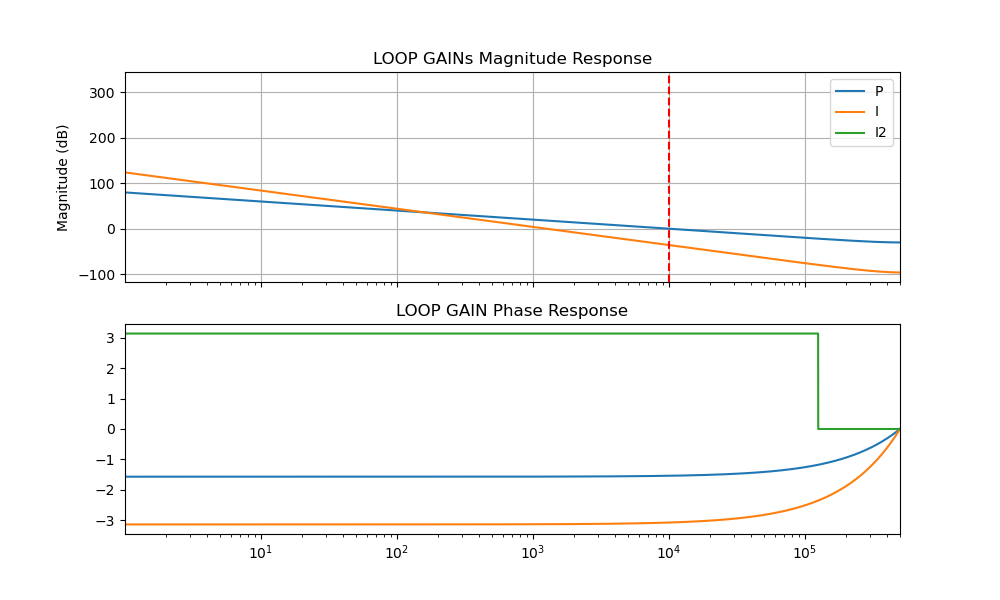

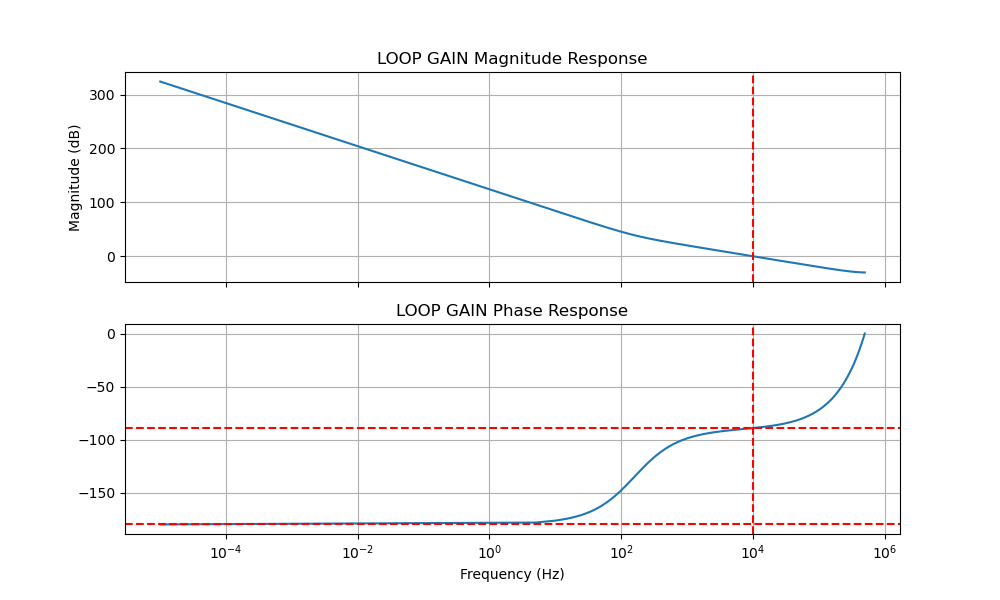

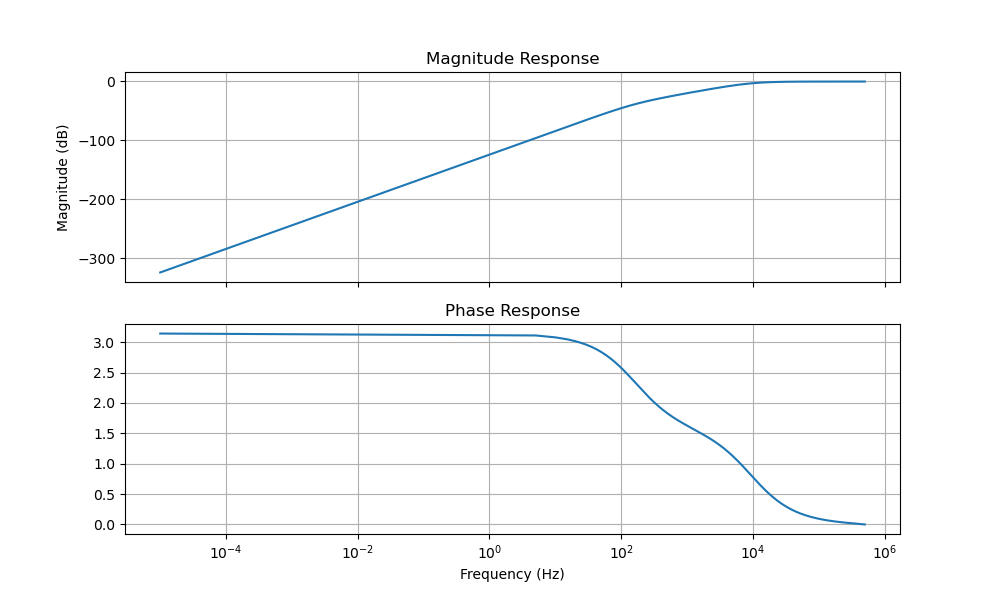

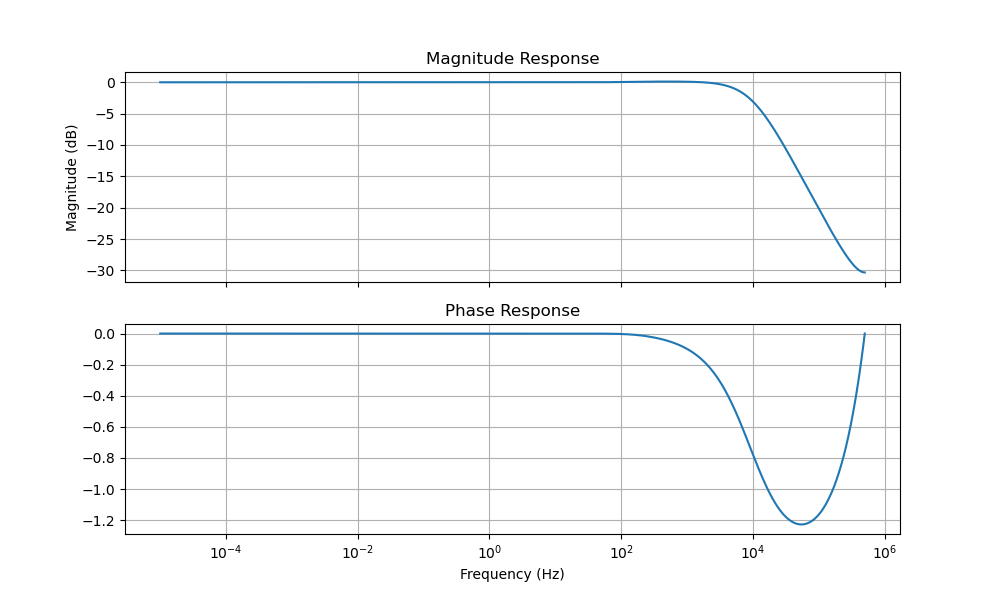

In [62]:
P = 0.01 # For digital PLL, P = fug/fs, hence, fug = P * fs
I = 0.00001
param = {'P': P, 'I': I, 'I2': 0}

freqs, P_GAIN, I_GAIN, I2_GAIN, LOOP_GAIN, FORWARD_LOOP_TF, ERROR_TF = PLL.PLL_TF(param, fs)

plotPII2(P, I, 0, freqs, verbosePlot=True)
plotLoopGain(LOOP_GAIN, freqs, verbosePlot=True)
print("Phase Error Transfer Function")
plotTF(ERROR_TF, freqs, verbosePlot=True) # THis is phase rejection at the phase detector
print("Additive Error Transfer Function")
plotTF(LOOP_GAIN/(LOOP_GAIN+1), freqs, verbosePlot=True) # THis is phase rejection at the phase detector

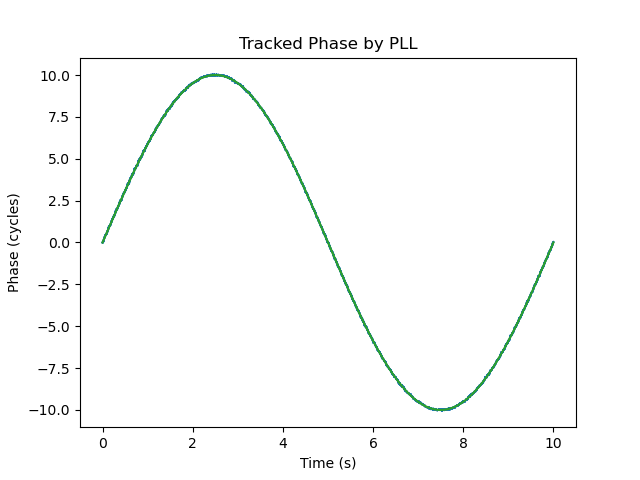

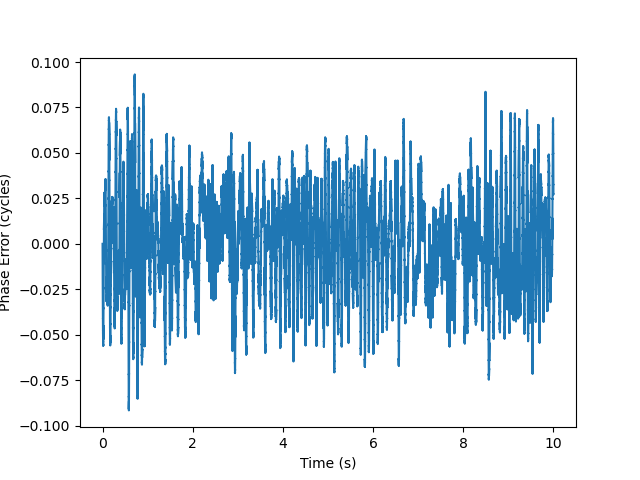

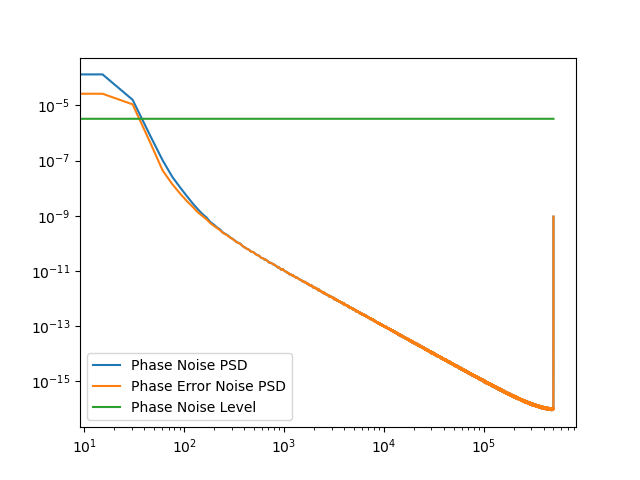

In [63]:
adjustment, phaseTracked = PLL.PLL(IQ_test_additive, P = P, I=I, I2=0)

plt.figure()
plt.plot(t, phaseTracked, label = "PLL Adjustment", color = "tab:blue")
plt.plot(t, signal, label = "Signal", color = "tab:green")
#plt.plot(t, phaseTracked - signal, label = "PLL Phase Error", color = "tab:orange")
plt.xlabel("Time (s)")
plt.ylabel("Phase (cycles)")
plt.title("Tracked Phase by PLL")

error = phaseTracked - signal # gentle reminder that the error port, is an imaginary concept i.e. it can't directly be measured. We can however take the difference!

plt.figure()
plt.plot(t, error, label = "Phase Error", color = "tab:blue")
plt.xlabel("Time (s)")
plt.ylabel("Phase Error (cycles)")

f, phasePSD = welch(phaseTracked, fs, nperseg = 1024*64)
f, phasePSD2 = welch(error, fs, nperseg = 1024*64)

plt.figure()
plt.plot(f, phasePSD, label = "Phase Noise PSD")
plt.plot(f, phasePSD2, label = "Phase Error Noise PSD")
plt.plot(f, add_phase_lvl*np.ones_like(f), label = "Phase Noise Level") # Gerberding talks about root 2 factor
plt.xscale("log")
plt.yscale("log")
plt.legend()

# This is in a great state now! Can simulate weak light statistics

# Weak Light Tuning

- Need to think about tuning when the model is largely unkown
  - i.e. it's going to be hard to completely model the pluto's rf chain
  - Best bet is to tune off bandwidth, by looking at noise PSDs
    - Can look at where noise rolls off to figure out bandwidth
